# Mean-field model

Following the Methods section in the paper, the coupled 5-state mean-field model that describes the evolution of the expected number of agents at each resource level $k$ is:

\begin{equation}
   \frac{d  n_{k {\gamma}} }{dt}= w_k \left(1 - \frac{\sum_{\gamma'} n_{k  {\gamma}'}}{w_k M} \right) \sum_{i}(b_i + \gamma_i) n_{i {\gamma}}  -\sum_i w_i \left(1 - \frac{\sum_{\gamma'} n_{i  {\gamma}'}}{w_i M} \right)\gamma_k n_{k {\gamma}},
   \label{eqn:meanfieldhighdensity}
 \end{equation}
 
 where $n_{k{\gamma}}$ is the number of agents at sites of resource level $k$ with phenotype $\gamma$ and $M$ is the total number of sites, with $w_k M$ the expected number of sites of resource level $k$, which sets a maximum occupancy for each state.
 
 In the low-density limit, where $\sum_{\gamma'} n_{k  {\gamma}'}\ll w_k M$, the above dynamics can be decoupled:
 \begin{equation}
   \frac{d  n_{k{\gamma}} }{dt}=  w_k \sum_{i}(b_i+\gamma_i) n_{i{\gamma}} -\gamma_k n_{k {\gamma}}
   \label{eqn:meanfield}
 \end{equation}
 
 After a duration of time $T = 0.3$ (arbitrary units) a catastrophe occurs and the population sizes are scaled by $N_0/\sum_{k,\gamma} n_{k\gamma}(T)$ to model the culling of the population back down to its initial size $N_0$. The system of equations is solved again using the rescaled population size as the new initial condition. These catastrophes occur even in the low density limit in which the phenotypes dynamically decouple, and this is the mechanism by which different phenotypes remain coupled even in the low density limit.
 
Note the birth rate is taken to be $b=[0,1,2,3,5]$ instead of $[0,1,2,3,4]$ as in the agent-based stochastic simulations. This has been pointed out in the paper and is to account for the slight numerical discrepancy between the two models.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from numpy import linalg as LA
from scipy.misc import derivative
from scipy.optimize import minimize,root_scalar
from scipy.integrate import solve_ivp
import itertools
import pickle
import matplotlib.style as style
import string
style.use('seaborn-colorblind')
%autosave 10

Autosaving every 10 seconds


## Low-density limit

In the low-density limit the mean-field equations can be dynamically decoupled, resulting in a system of linear equations for each phenotype in the 5-state model. We can solve the decoupled 5-state mean-field equations for each phenotype independently and simply scale the population sizes of all phenotypes by the same factor when a catastrophe occurs.

Because the decoupled dynamics are linear we are able to derive an effective objective function, which is the largest eigenvalue of the coefficient matrix. The phenotype that maximizes the largest eigenvalue will be the most competitive phenotypes in the long-time limit. We also show that there is only one positive eigenvalue for this coefficient matrix empirically. Using the largest eigenvalue as the objective function, we can also show a transition of $\gamma_4$ from $\gamma_{min}$ to $\gamma_{max}$ when $b_5$ crosses the critical value, which is also dependent on the resource distribution characterized by the exponential coefficient $c$.

### Largest eigenvalue: an effective objective function
#### First, we empirically show there is only one positive eigenvalue and it can serve as an effective objective function

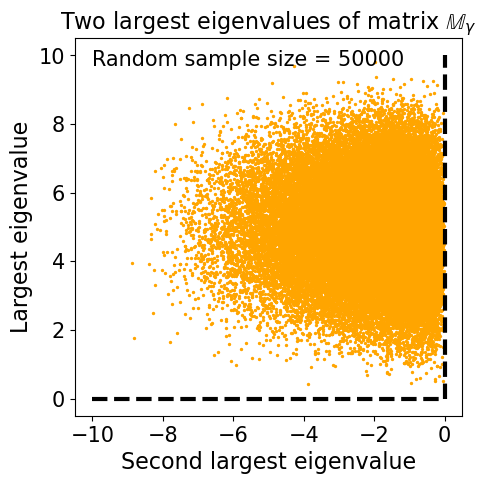

In [4]:
c = 0
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0)

def max_eigen2(h, b):
    """Generate the coefficient matrix and calculate the largest two eigenvalues"""
    m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
    return np.sort(LA.eig(m)[0])[-2:][::-1]

def plot_largest2eigenvalues(sample_size=100000, random_birth_rate=False,savefig=False):
    """Plot the scatter plot of the largest 2 eigenvalues for randomly generated hopping rate with or without random birth rate"""      
    eigen = [max_eigen2(np.random.rand(5)*10, b=np.random.rand(5)*10 if random_birth_rate else [0,1,2,3,4] ) for _ in range(sample_size)]
    fig = plt.figure(dpi=100, figsize=(5, 5))
    ax = plt.subplot()
    sc = ax.scatter(np.array(eigen)[:, 1], np.array(
        eigen)[:, 0], s=2, color='orange')
    ax.vlines(0, 0, 10, linestyles='dashed', lw=3, color='k')
    ax.hlines(0, -10, 0, linestyles='dashed', lw=3, color='k')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(
        'Two largest eigenvalues of matrix $\mathbb{M}_\gamma}$', fontsize=16)
    ax.text(-10, 9.7, 'Random sample size = {}'.format(sample_size), fontsize=15)
    plt.xlabel("Second largest eigenvalue", fontsize=16)
    plt.ylabel("Largest eigenvalue", fontsize=16)
    if savefig:
        fig.savefig('./Figures/Figure_6_eigenvalues.pdf', bbox_inches='tight')
    plt.show()

plot_largest2eigenvalues(sample_size=50000, random_birth_rate=True,savefig=False)

#### Secondly, we show the largest eigenvalue can predict a transition in the dominant value of $\gamma_4$ for different $b_5$

In [121]:
root_scalar(derivative_h4, bracket=[0,20]).root

19.08954706109046

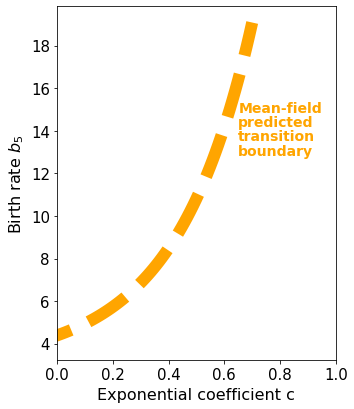

In [132]:
def derivative_h4(b5):
    '''Calculate the derivative of max eigenvalue wrt. gamma_4 at gamma_4=5'''
    b = [0, 1, 2, 3, b5]
    def max_eigen(h4):
        h = [10, 10, 10, h4, 0]
        m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real

root_b5_5 = []
for c in np.linspace(-0.1, 0.7, 80):
    p = [np.exp(-i*c) for i in range(5)]
    w = p/np.sum(p)
    root_b5_5.append(root_scalar(derivative_h4, bracket=[3,100]).root) # find the root of b5 that makes the derivative 0, thus the transition point

fig,ax=plt.subplots(figsize=(5,6.5))
ax.plot(np.linspace(-0.1, 0.7, 80),root_b5_5,'--', color='orange', linewidth=12)
ax.set_xlabel('Exponential coefficient c', fontsize=16, labelpad=5)
ax.set_ylabel('Birth rate $b_5$', fontsize=16, labelpad=5)
ax.set_xlim(0,1)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.text(0.65, 0.7, 'Mean-field', transform=ax.transAxes,
           size=14, color='orange', weight='bold')
ax.text(0.65, 0.66, 'predicted', transform=ax.transAxes,
           size=14, color='orange', weight='bold')
ax.text(0.65, 0.62, 'transition', transform=ax.transAxes,
           size=14, color='orange', weight='bold')
ax.text(0.65, 0.58, 'boundary', transform=ax.transAxes,
           size=14, color='orange', weight='bold')
plt.show()

## Coupled mean-field model at different densities
We first create the coupled mean-field differential equation by stacking together the coefficient matrices for each phenotype, and then solve it with Scipy solve_ivp.

In [92]:
c = 0 # exponential coefficient, c=0 is equivilent to discrete uniform distribution
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0) # probability of each resource levels

x = [0, 2, 4, 6, 8, 10]
hopping_discrete = [p for p in itertools.product(x, repeat=5)] # all the possible discretized phenot

b=[0,1,2,3,5]

def coupled_coef_matrix(t,y,K=1,hopping=np.array(hopping_discrete)):
    """
        M: total number of sites
        K: carrying capacity of each site
        w: fraction of number of sites for each resource level; uniform resource has w = [0.2,0.2,0.2,0.2,0.2]
    """
    couplings=[(1-np.sum(y.reshape(-1,5)[:,i])/(w[i]*M*K)) for i in range(5)]
    coupling_sum=np.sum([couplings[i]*w[i] for i in range(5)])
    block=[]
    for i in range(len(hopping)):
        h=hopping[i]
        block.append((np.array([[w[j]*couplings[j]*(b[i]+h[i]) for i in range(5)] for j in range(5)])-np.diag([coupling_sum*h[j] for j in range(5)]))@y[i*5:i*5+5])
    return np.array(block).reshape(-1)

def cal_average_std(sol, time_steps, hoppings):
    """
    Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation

    Args:
        sol (array_like): numerical solution of the coupled mean-field equation from ODE solver
        time_steps (int): number of steps
        hoppings (array_like): all possible hopping rates in the discretized space

    Returns:
        [tuple of ndarrays]: mean hopping rate and its std at each time step
    """
    fitness = [[np.sum(sol[i][:, t]) for i in range(len(hoppings))]
               for t in range(time_steps)]
    prob = [fitness[t]/np.sum(fitness[t]) for t in range(time_steps)]
    avehop = np.array([np.sum([prob[t][i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0) for t in range(time_steps)])
    variance = np.array([np.sum([prob[t][i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop[t]**2 for t in range(time_steps)])
    return avehop, np.sqrt(variance)

def solve_coupled(n):
    sol=[solve_ivp(coupled_coef_matrix, [0,0],np.array([500/len(hopping_discrete)/5]*(5*len(hopping_discrete))))]
    t_eval=np.linspace(0,0.3,10)  
    
    for i in range(1,n):
#         if i%50==0:
#             print('Iteration {}'.format(i))
        sol.append(solve_ivp(coupled_coef_matrix, [0,0.3], sol[i-1].y[:,-1]*np.sum(sol[0].y[:,-1])*(1/np.sum(sol[i-1].y[:,-1])),t_eval=t_eval))
    sol=np.concatenate(tuple(sol[i].y for i in range(n)),1)
    return sol

In [7]:
# Numerically solve the coupled mean-field equation for different densities. Each density takes around 2 hours to run
# To run the solver, change False to True in the condition below
if False:
    for M in [i**2 for i in [128,64,48,40,32,26,24,23]]:
        print("Density {:.0%}".format(500/M)) 
        sol = solve_coupled(n=2001)
        full_sol.append(sol)
        with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "wb") as fp: 
            pickle.dump(sol[:,::10], fp)

Text(0.5, 0.05, 'Iterations')

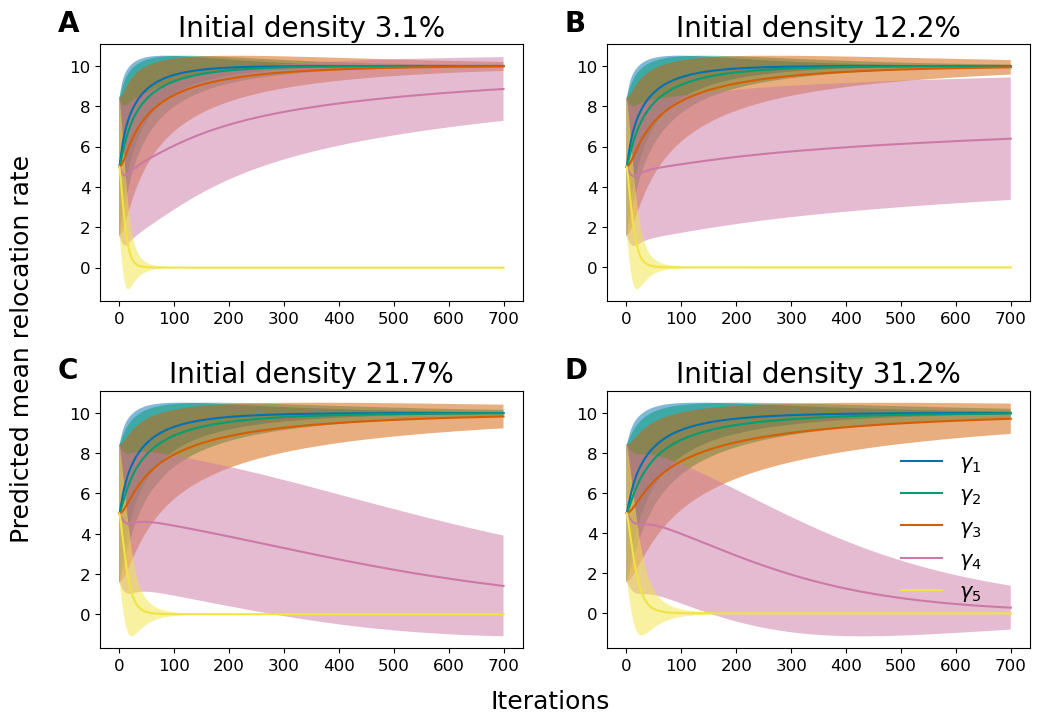

In [8]:
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1],hspace=0.35, wspace=0.2))
for j in range(4):
    M = [_**2 for _ in [128, 64, 48, 40]][j]
    with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "rb") as fp:
        full_sol = pickle.load(fp)
    ave,std= cal_average_std(full_sol.reshape(-1,5,2001)[:,:,:701],701,hoppings=hopping_discrete)
    t_eval= np.linspace(0,700,701)
    for i in range(5):
        ax[j//2, j % 2].plot(t_eval,np.array(ave)[:,i],label="$\gamma_{}$".format(i+1))
        ax[j//2, j % 2].fill_between(t_eval,np.array(ave)[:,i]-np.array(std)[:,i], np.array(ave)[:,i]+np.array(std)[:,i], alpha=0.5)
    ax[j//2, j % 2].tick_params(axis='both', which='major', labelsize=12)
    ax[j//2, j % 2].text(-0.1, 1.05, string.ascii_uppercase[j], transform=ax[j//2, j % 2].transAxes,
                             size=20, weight='bold')
    ax[j//2, j % 2].set_title('Initial density {:.1%}'.format(500/M),
                                  fontsize=20)
ax[1, 1].legend(frameon=False, fontsize=15,
                loc='lower left', bbox_to_anchor=(0.65, 0.1))
fig.text(0.05, 0.5, 'Predicted mean relocation rate',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Iterations', fontsize=18, ha='center')
plt.show()

Text(0.5, 1.0, 'Mean-field prediction at different densities')

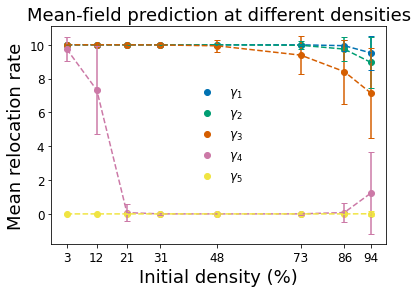

In [9]:
def cal_ave_std_last_step(sol,hoppings=hopping_discrete): # at last time step
    density_total=np.sum(np.array(sol)[:,-1].reshape(len(hoppings),5),1)
    prob = density_total/np.sum(density_total)
    avehop = np.sum([prob[i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0)
    variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop**2)
    return (avehop,np.sqrt(variance))

ave_mf_density=[]
std_mf_density=[]
density=[]
for M in [i**2 for i in [128,64,48,40,32,26,24,23]]:
    with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "rb") as fp: 
        full_sol=pickle.load(fp)
    _ave,_std = cal_ave_std_last_step(full_sol)
    ave_mf_density.append(_ave)
    std_mf_density.append(_std)
    density.append(int(50000/M))
fig,ax=plt.subplots()
for i in range(5):
    ax.scatter(density,np.array(ave_mf_density).T[i],label='$\gamma_{}$'.format(i+1))
    ax.errorbar(density,np.array(ave_mf_density).T[i],yerr=np.array(std_mf_density).T[i], capsize=3, linestyle='--')
ax.legend(frameon=False,fontsize=12)
ax.set_xticks(density)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Initial density (%)', fontsize=18)
ax.set_ylabel('Mean relocation rate', fontsize=18)
ax.set_title('Mean-field prediction at different densities', fontsize=18)
plt.show()

Text(0.5, 0.05, 'Iterations')

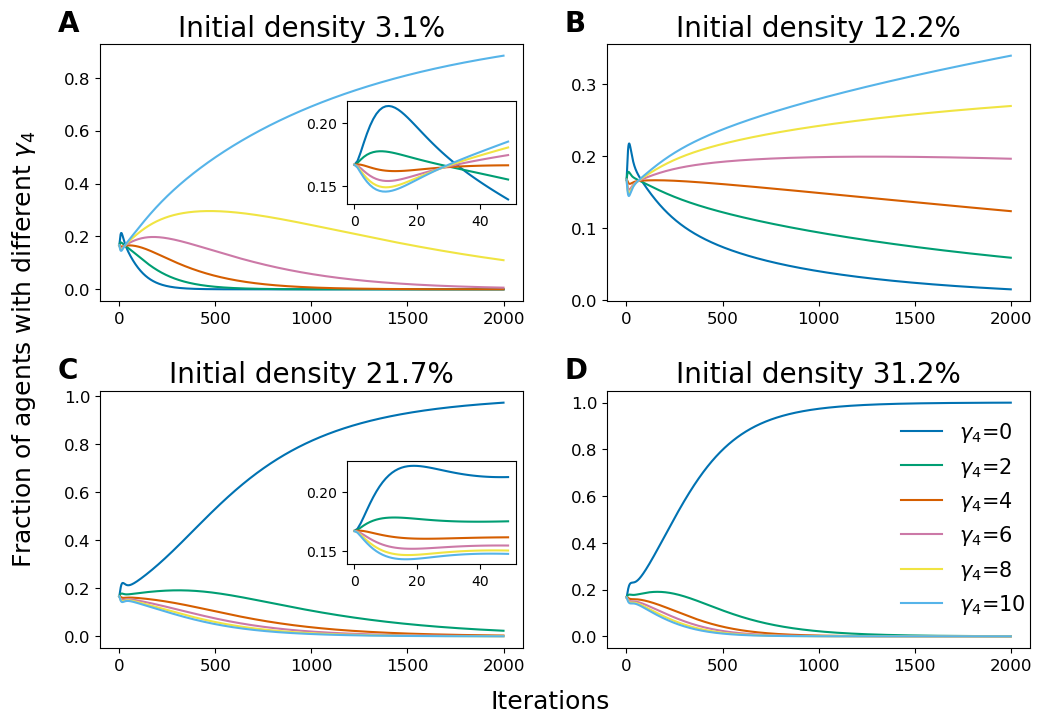

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1],hspace=0.35, wspace=0.2))
axins = inset_axes(ax[0,0], width="40%", height="40%", loc=4,bbox_to_anchor=(0,0.35,1,1),bbox_transform=ax[0,0].transAxes)
axins2 = inset_axes(ax[1,0], width="40%", height="40%", loc=4,bbox_to_anchor=(0,0.3,1,1),bbox_transform=ax[1,0].transAxes)

x = [0, 2, 4, 6, 8, 10]
hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])
for j in range(4):
    M = [_**2 for _ in [128, 64, 48, 40]][j]
    with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "rb") as fp:
        full_sol = pickle.load(fp)
    prop = np.array([[np.sum([np.sum(full_sol[i*5:i*5+5, t]) for i in [i for i in range(len(
        hopping_discrete)) if hopping_discrete[i, -2] == j]]) for t in range(2001)] for j in [0, 2, 4, 6, 8, 10]])
    for i in range(6):
        ax[j//2, j % 2].plot(prop[i, :]/np.sum(prop, axis=0),
                             label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
        if j == 0:
            axins.plot(prop[i, :50]/np.sum(prop[:,:50], axis=0),
                             label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
        if j == 2:
            axins2.plot(prop[i, :50]/np.sum(prop[:,:50], axis=0),
                             label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
    ax[j//2, j % 2].tick_params(axis='both', which='major', labelsize=12)
    ax[j//2, j % 2].text(-0.1, 1.05, string.ascii_uppercase[j], transform=ax[j//2, j % 2].transAxes,
                         size=20, weight='bold')
    ax[j//2, j % 2].set_title('Initial density {:.1%}'.format(500/M),
                              fontsize=20)
ax[1, 1].legend(frameon=False, fontsize=15,
                loc='lower left', bbox_to_anchor=(0.65, 0.05))

fig.text(0.05, 0.5, 'Fraction of agents with different $\gamma_4$',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Iterations', fontsize=18, ha='center')
plt.show()

## Transition of $\gamma_4$ at different $b_5$

In [ ]:
c = 0 # exponential coefficient, c=0 is equivilent to discrete uniform distribution
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0) # probability of each resource levels
if True:
    for b5 in [3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25]:
        b=[0,1,2,3,b5]
        print(b)
        M=128*128 
        sol = solve_coupled(n=701)
        with open('./evolve_data/b5_c_plane_mf/b5_{}_c_{}'.format(b5,c), "wb") as fp: 
            pickle.dump(sol[:,::10], fp)

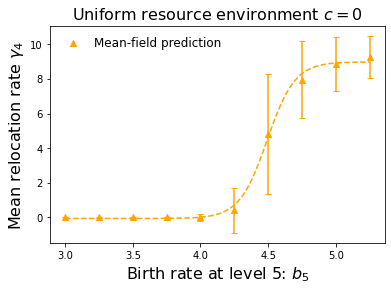

In [99]:
x = [0,2,4,6,8,10]
hopping_discrete=np.array([p for p in itertools.product(x, repeat=5)])

def cal_ave_std_last_step(sol,hoppings=hopping_discrete): # at last time step
    density_total=np.sum(np.array(sol)[:,-1].reshape(len(hoppings),5),1)
    prob = density_total/np.sum(density_total)
    avehop = np.sum([prob[i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0)
    variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop**2)
    return (avehop,np.sqrt(variance))

ave_std_c0=[]
for b5 in [3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25]:
    with open('./evolve_data/b5_c_plane_mf/b5_{}_c_{}'.format(b5,0), "rb") as fp: 
        full_sol = pickle.load(fp)
    ave_std_c0.append(cal_ave_std_last_step(full_sol))
mean_meanfield=np.array(ave_std_c0)[:,0,3]
std_meanfield=np.array(ave_std_c0)[:,1,3]
b5_meanfield=[3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25]
(a_m, b_m, c_m,d_m), _ = opt.curve_fit(func, b5_meanfield,mean_meanfield,p0=[0,1,1,1])

color_mf='orange'
plt.scatter(b5_meanfield, mean_meanfield, marker='^',
                 color=color_mf, label='Mean-field prediction')
plt.errorbar(b5_meanfield, mean_meanfield, yerr=std_meanfield,
                  capsize=3, linestyle='None', color=color_mf)
plt.plot(np.linspace(3, 5.25,100), [func(i, a_m, b_m, c_m, d_m)
                                         for i in np.linspace(3, 5.25, 100)], '--', color=color_mf)
plt.xlabel('Birth rate at level 5: $b_5$', fontsize=16, labelpad=5)
plt.ylabel('Mean relocation rate $\gamma_4$',
         fontsize=16)
plt.title('Uniform resource environment $c=0$',fontsize=16)
plt.legend(frameon=False,fontsize=12)
plt.show()

In [93]:
c = 0.5 # exponential coefficient, c=0 is equivilent to discrete uniform distribution
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0) # probability of each resource levels
if True:
    for b5 in [4,6,8,9,10,11,12,13,14,16,18]:
        b=[0,1,2,3,b5]
        print(b)
        M=128*128 
        sol = solve_coupled(n=701)
        with open('./evolve_data/b5_c_plane_mf/b5_{}_c_{}'.format(b5,c), "wb") as fp: 
            pickle.dump(sol[:,::10], fp)

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 6]
[0, 1, 2, 3, 8]
[0, 1, 2, 3, 9]
[0, 1, 2, 3, 10]
[0, 1, 2, 3, 11]
[0, 1, 2, 3, 12]
[0, 1, 2, 3, 13]
[0, 1, 2, 3, 14]
[0, 1, 2, 3, 16]
[0, 1, 2, 3, 18]


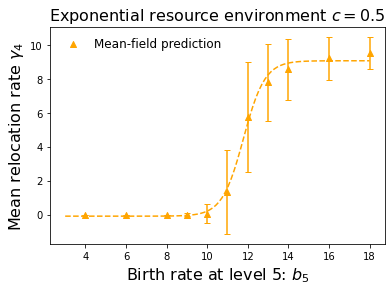

In [98]:
ave_std_c05=[]
for b5 in [4,6,8,9,10,11,12,13,14,16,18]:
    with open('./evolve_data/b5_c_plane_mf/b5_{}_c_{}'.format(b5,0.5), "rb") as fp: 
        full_sol = pickle.load(fp)
    ave_std_c05.append(cal_ave_std_last_step(full_sol))
mean_meanfield_exp=np.array(ave_std_c05)[:,0,3]
std_meanfield_exp=np.array(ave_std_c05)[:,1,3]
b5_meanfield_exp=[4,6,8,9,10,11,12,13,14,16,18]
(a_m_exp, b_m_exp, c_m_exp,d_m_exp), _ = opt.curve_fit(func, b5_meanfield_exp,mean_meanfield_exp,p0=[0,1,1,1])

color_mf='orange'
plt.scatter(b5_meanfield_exp, mean_meanfield_exp, marker='^',
                 color=color_mf, label='Mean-field prediction')
plt.errorbar(b5_meanfield_exp, mean_meanfield_exp, yerr=std_meanfield_exp,
                  capsize=3, linestyle='None', color=color_mf)
plt.plot(np.linspace(3, 18,100), [func(i, a_m_exp, b_m_exp, c_m_exp, d_m_exp)
                                         for i in np.linspace(3, 18, 100)], '--', color=color_mf)
plt.xlabel('Birth rate at level 5: $b_5$', fontsize=16, labelpad=5)
plt.ylabel('Mean relocation rate $\gamma_4$',
         fontsize=16)
plt.title('Exponential resource environment $c=0.5$',fontsize=16)
plt.legend(frameon=False,fontsize=12)
plt.show()